# SNS injection painting

In [1]:
import sys
import importlib

import numpy as np
from matplotlib import pyplot as plt, animation
from tqdm import tqdm, trange
import proplot as plot 

sys.path.append('/Users/46h/Research/accphys/')
from tools import plotting as myplt
from tools import animation as myanim
from tools import utils
from tools import beam_analysis as ba

plot.rc['animation.html'] = 'jshtml'
plot.rc['savefig.dpi'] = 'figure'
plot.rc['figure.facecolor'] = 'white'
plot.rc['axes.grid'] = False
plot.rc['grid.alpha'] = 0.04

## Matched eigenvector 

In [2]:
# matched_eigvec = np.load('matched_eigenvector.npy')
# matched_env_params = np.load('matched_env_params.npy')

# eps = 40e-6 # intrinsic emittance [mm mrad]
# n_parts = 10000
# radii = np.sqrt(np.random.uniform(0, 4 * eps, size=(n_parts, 1)))
# phases = np.linspace(0, 2 * np.pi, n_parts).reshape(n_parts, 1) # eigenvector phase [rad]
# eigvecs = np.tile(matched_eigvec, (n_parts, 1))
# X = np.real(radii * eigvecs * np.exp(-1j * phases))

# myplt.corner(1e3 * X, 1e3 * matched_env_params);

In [3]:
folder = '_saved/production/'

## Injection region closed orbit

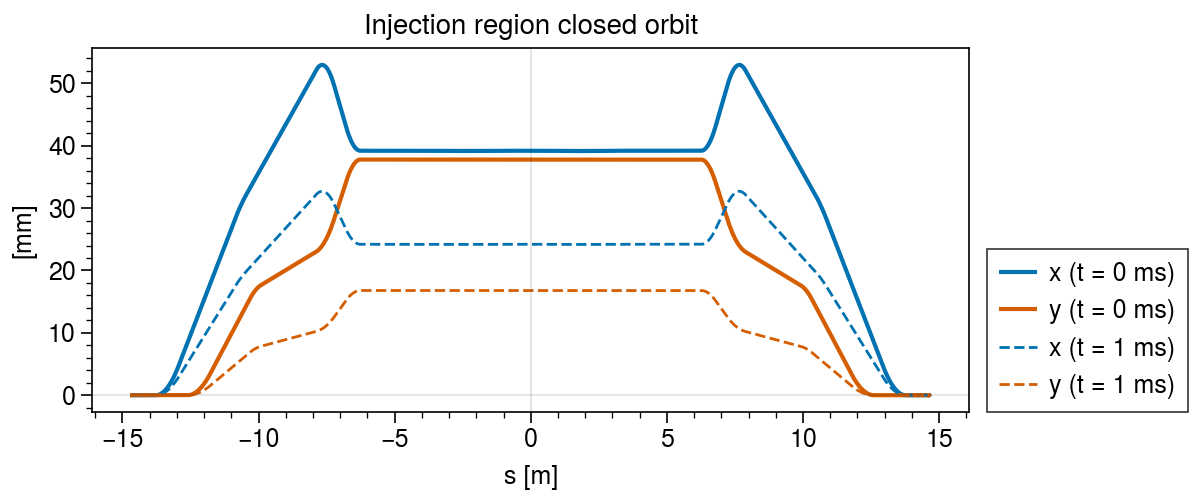

In [4]:
inj_region_coords_t0 = np.load(folder + 'inj_region_coords_t0.npy')
inj_region_coords_t1 = np.load(folder + 'inj_region_coords_t1.npy')
inj_region_positions_t0 = np.load(folder + 'inj_region_positions_t0.npy')
inj_region_positions_t1 = np.load(folder + 'inj_region_positions_t1.npy')
inj_region_positions_t0 -= 0.5 * inj_region_positions_t0[-1]
inj_region_positions_t1 -= 0.5 * inj_region_positions_t1[-1]

fig, ax = plot.subplots(figsize=(6, 2.5))
ax.plot(inj_region_positions_t0, inj_region_coords_t0[:, 0])
ax.plot(inj_region_positions_t0, inj_region_coords_t0[:, 2])
ax.format(cycle='colorblind')
ax.plot(inj_region_positions_t1, inj_region_coords_t1[:, 0], ls='--', lw=1)
ax.plot(inj_region_positions_t1, inj_region_coords_t1[:, 2], ls='--', lw=1)
ax.format(title='Injection region closed orbit')
ax.legend(labels=('x (t = 0 ms)', 'y (t = 0 ms)', 'x (t = 1 ms)', 'y (t = 1 ms)'), 
          ncols=1, loc=(1.02, 0), handlelength=1.5);
ax.axvline(0, c='k', lw=0.75, alpha=0.1)
ax.axhline(0, c='k', lw=0.75, alpha=0.1)
ax.format(xlabel='s [m]', ylabel='[mm]') 

# Plot kicker positions
# hkick_positions = [-12.8738290, -10.1838290, 11.13989262, 13.82989262]
# vkick_positions = [-11.7138290, -9.64382900, 10.59989262, 12.66989262]
# for hkick_position in hkick_positions:
#     ax.axvline(hkick_position, color='pink', zorder=0)
# for vkick_position in vkick_positions:
#     ax.axvline(vkick_position, color='grey', zorder=0)
    
plt.savefig('_output/figures/inj_region_closed_orbit.png', facecolor='white', dpi=500)

## Kicker strengths

In [5]:
kicker_angles_t0 = np.loadtxt(folder + 'kicker_angles_t0.dat')
kicker_angles_t1 = np.loadtxt(folder + 'kicker_angles_t1.dat')
kicker_names = ['ikickh_a10', 'ikickv_a10', 'ikickh_a11', 'ikickv_a11',
                'ikickv_a12', 'ikickh_a12', 'ikickv_a13', 'ikickh_a13']

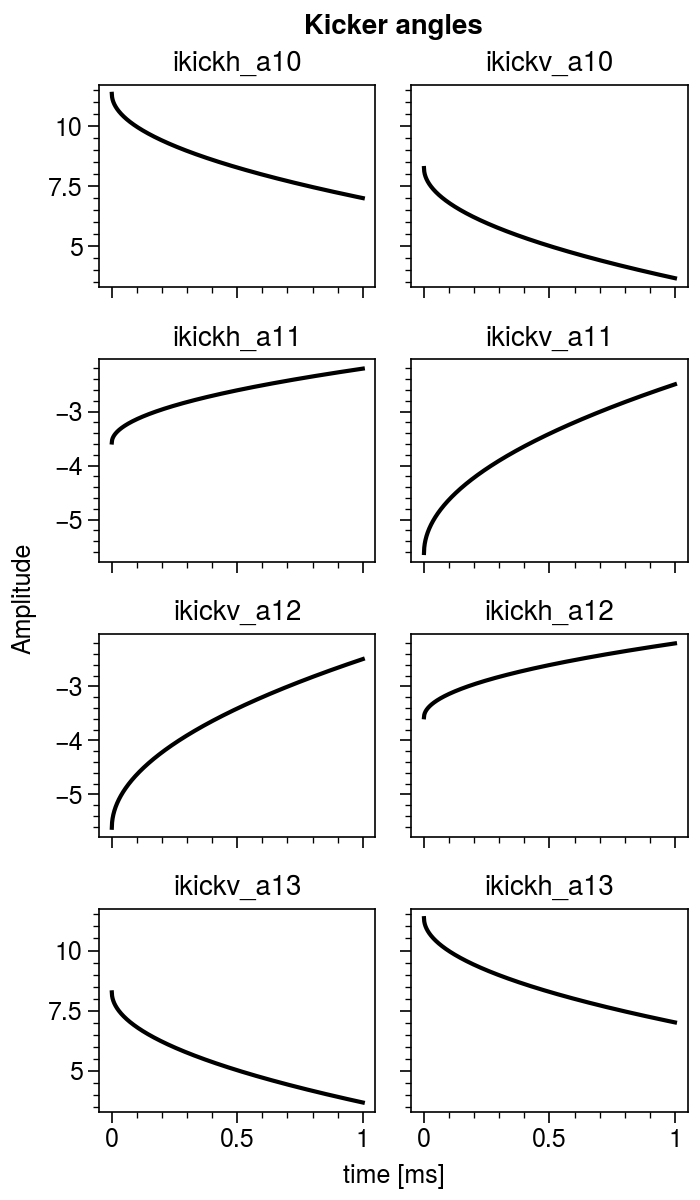

In [6]:
def waveform(t, k0, k1):
    return k0 - (k0 - k1)*np.sqrt(t)

t = np.linspace(0, 1, 1000)

fig, axes = plot.subplots(nrows=4, ncols=2, figsize=(3.5, 6))
for k0, k1, name, ax in zip(kicker_angles_t0, kicker_angles_t1, kicker_names, axes):
    ax.plot(t, 1000 * waveform(t, k0, k1), c='k')
    ax.format(title=name)
axes.format(ylabel='Amplitude', suptitle='Kicker angles', xlabel='time [ms]')
plt.savefig('_output/figures/kicker_angles.png', facecolor='w', dpi=500)

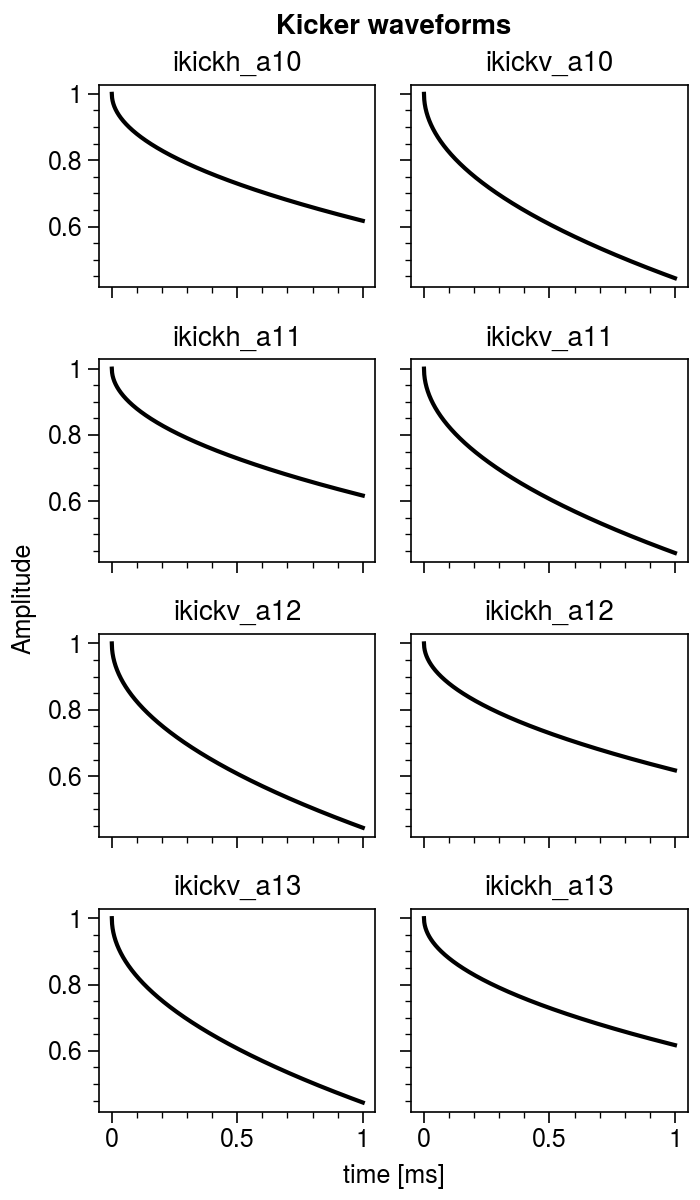

In [7]:
fig, axes = plot.subplots(nrows=4, ncols=2, figsize=(3.5, 6))
for k0, k1, name, ax in zip(kicker_angles_t0, kicker_angles_t1, kicker_names, axes):
    ax.plot(t, waveform(t, 1.0, k1/k0), c='k')
    ax.format(title=name)
axes.format(ylabel='Amplitude', suptitle='Kicker waveforms', xlabel='time [ms]')
plt.savefig('_output/figures/kicker_waveforms.png', facecolor='w', dpi=500)

## TBT coordinates 

In [8]:
coords = utils.load_stacked_arrays(folder + 'coords.npz')

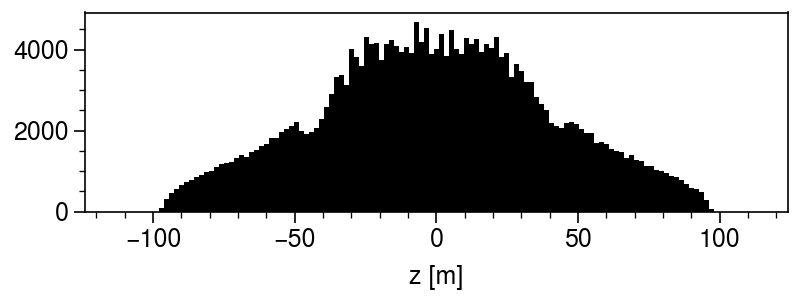

In [9]:
X = coords[-1]
fig, ax = plot.subplots(figsize=(4, 1.5))
ax.hist(X[:, 4], histtype='stepfilled', bins='auto', color='black')
ax.set_xlabel("z [m]")
ax.set_xlim(-248/2, 248/2);

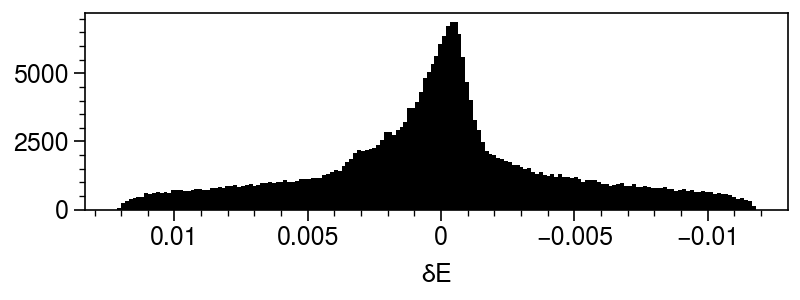

In [10]:
fig, ax = plot.subplots(figsize=(4, 1.5))
ax.hist(X[:, 5], histtype='stepfilled', bins='auto', color='black')
ax.set_xlabel(r"$\delta$E");

In [11]:
foil_pos = (49.2, 46.8)
coords_foil_frame = []
for X in coords:
    Y = np.copy(X)
    Y[:, 0] -= foil_pos[0]
    Y[:, 2] -= foil_pos[1]
    coords_foil_frame.append(Y)

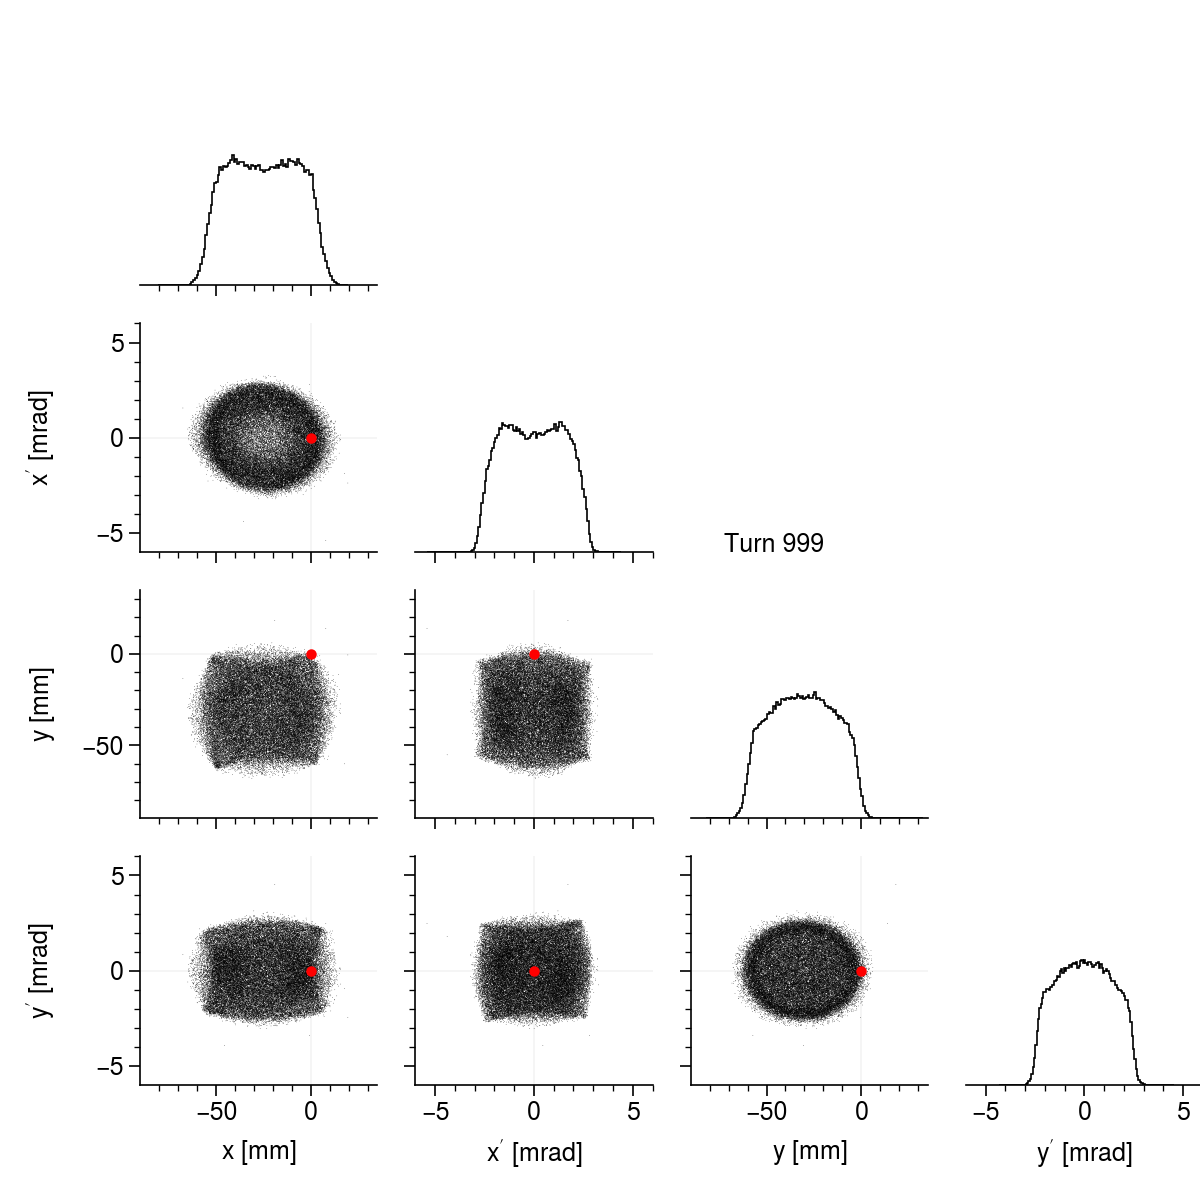

In [12]:
limits = ((-90, 35), (-6, 6)) # ((x_min, x_max), (y_min, y_max))
turn = 999
axes = myplt.corner(
    coords_foil_frame[turn][:, :4], 
    limits=limits, 
    zero_center=True,
    samples=50000, 
    s=0.2,
    diag_kws=dict(color='k'),
    text='Turn {}'.format(turn),
    c='k',
)
for i in range(1, 4):
    for j in range(i):
        ax = axes[i, j]
        ax.scatter(0, 0, c='r', s=10, zorder=99)
        axes[i, j].axvline(0, c='k', lw=0.75, alpha=0.04, zorder=0)
        axes[i, j].axhline(0, c='k', lw=0.75, alpha=0.04, zorder=0)
plt.savefig('_output/figures/corner.png', facecolor='w', dpi=300)

In [13]:
X = coords[turn]
Sigma = np.cov(X.T)
Sigma = Sigma[:4, :4]
print(Sigma)
print(ba.intrinsic_emittances(Sigma))
print(ba.apparent_emittances(Sigma))

[[ 3.06451937e+02 -1.93785767e+00 -3.11876960e-01  3.70776472e-01]
 [-1.93785767e+00  2.17749026e+00 -4.70782889e-01  2.20337555e-02]
 [-3.11876960e-01 -4.70782889e-01  2.66012313e+02 -1.54677098e-01]
 [ 3.70776472e-01  2.20337555e-02 -1.54677098e-01  1.82420595e+00]]
(25.81021268183141, 21.976042053909136)
(25.75928602227152, 22.028102956535204)


In [ ]:
anim = myanim.corner(coords_foil_frame, figsize=6, skip=9, pad=0, zero_center=False, samples=50000, 
                     text_fmt='Turn {}', diag_kws=dict(color='black'), color='black', ms=0.3)
anim

The cell below saves a high quality gif by calling `myplt.corner` a bunch of times. It's pretty slow. Also, for some reason, transparent markers become non-transparent in the saved gif. 

In [ ]:
# import gif
# gif.options.matplotlib["dpi"] = 300

# turns = np.arange(0, len(coords))

# @gif.frame
# def getframe(i):
#     axes = myplt.corner(coords_foil_frame[i], limits=(80, 6), 
#                         text='Turn = {}'.format(turns[i]))
#     axes[2, 0].scatter(0, 0, c='r', s=10, zorder=99);
#     return axes

# frames = []
# for i in trange(0, 1000, 10):
#     frame = getframe(i)
#     frames.append(frame)
    
# gif.save(frames, '_output/figures/example.gif', duration=7.0, unit="s", between="startend")

## Beam statistics

In [ ]:
moments_list = []
for X in tqdm(coords):
    Sigma = np.cov(X[:, :4].T)
    moments_list.append(ba.mat2vec(Sigma))
moments_list = np.array(moments_list)
    
stats = ba.Stats(1)
stats.read_moments(moments_list)

In [ ]:
fig, ax = plot.subplots(figsize=(3.5, 2.5))
plt_kws = dict(legend=False)
stats.twiss2D[['ex','ey']].plot(ax=ax, **plt_kws)
stats.twiss4D[['e1','e2']].plot(ax=ax, **plt_kws)
ax.legend(labels=[r'$\varepsilon_{}$'.format(v) for v in ['x', 'y', '1', '2']], ncols=1)
ax.format(ylabel='[mm mrad]', xlabel='Turn number', title='Emittances', grid=True);

In [ ]:
exey = (stats.twiss2D['ex'] * stats.twiss2D['ey']).values
e1e2 = (stats.twiss4D['e1'] * stats.twiss4D['e2']).values

fig, ax = plot.subplots(figsize=(3.5, 2.5))
ax.plot(e1e2, color='red')
ax.plot(exey, color='blue')
ax.legend(labels=[r'$\varepsilon_1\varepsilon_2$', 
                  r'$\varepsilon_x\varepsilon_y$'], ncols=1)
ax.format(xlabel='Turn number', ylabel=r'[mm$^2$ mrad$^2$]', 
          title='4D emittance', grid=True)

In [ ]:
fig, ax = plot.subplots(figsize=(3.5, 2.5))
ax.plot(1.0 - np.sqrt((e1e2) / (exey)), c='k')
ax.legend(labels=[r'C = 1 - $\sqrt{\frac{\varepsilon_1\varepsilon_2}{\varepsilon_x\varepsilon_y}}$'], ncols=1)
ax.format(xlabel='Turn number', ylabel=r'[mm$^2$ mrad$^2$]', 
          title='4D emittance', grid=True)

In [ ]:
fig, axes = plot.subplots(nrows=3, figsize=(3.5, 5.0), spany=False, aligny=True)
columns = (['bx','by'], ['ax','ay'], ['ex','ey'])
ylabels = (r'$\beta$ [m]', r'$\alpha$ [rad]', r'$\varepsilon$ [mm $\cdot$ mrad]')
for ax, col in zip(axes, columns):
    stats.twiss2D[col].plot(ax=ax, **plt_kws)
axes.format(xlabel='Turn number', grid=True)
axes[0].format(title='2D Twiss parameters')
myplt.set_labels(axes, ylabels, 'ylabel')

In [ ]:
fig, axes = plot.subplots(nrows=2, figsize=(3.5, 3.33), spany=False, aligny=True)
stats.twiss4D['u'].plot(color='k', ax=axes[0], **plt_kws)
stats.twiss4D['nu'].plot(color='k', ax=axes[1], **plt_kws)
axes.format(grid=True)
axes[0].format(ylabel='u')
axes[1].format(ylabel=r'$\nu$', yformatter='deg')

In [ ]:
stats.twiss2D

In [ ]:
stats.twiss4D